To start this file through pyspark use : $SPARK_HOME/bin/pyspark --jars /Users/seetha/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar --driver-class-path /Users/seetha/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar

In [1]:
#Foldername that contains data
FolderName = '/Volumes/Se/Se/RedBlueAF4Habenula/Data/Fish105_Block2_Blue1/'

#Other Stimulus parameters
light_type = ['Blue', 'Red']
time_end = 204
frames_per_sec = 1
median_filter_idx = 5
time_baseline = [0, 30]

#Region to analyze
region_to_analyze = 'dhb_AF4_AF9'
stimulus_to_analyze = 'BlueRed'

#Savemodes
savemode_loaddata = False
savemode_background = True
savemode_detrenddata = True
savemode_zscoredata = True
savemode_smootheddata = True

## Algorithm

### Start Thunder

In [2]:
# Create new config - To avoid maxResultSize error. Stop Spark context and reload ThunderContext
from thunder import ThunderContext
from pyspark import SparkConf, SparkContext

conf = (SparkConf()
    .set("spark.driver.maxResultSize", "0"))

sc.stop()
# Create new thunder context using the configuration
print 'Starting Thunder Now. Check console for details'
tsc = ThunderContext.start(appName="thunderpca", conf=conf)

# # Start Thunder and get thunder constant
# print 'Starting Thunder Now. Check console for details'
# from thunder import ThunderContext
# tsc = ThunderContext.start(appName="thunderpca")

Starting Thunder Now. Check console for details


### 1. Import libraries

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from thunder import Colorize
import os
import sys
from copy import copy
from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages

MODULES_DIR = '/Users/seetha/Desktop/my_cool_python_functions/for_opening_data/'
sys.path.append(os.path.dirname(MODULES_DIR))

from get_system_memory import PrintSystemMemory

In [4]:
filesep = os.path.sep
%matplotlib inline
sns.set_context('notebook', font_scale=1.5)
image = Colorize.image

Correct arguments given for this experiment type
For this experiment:
 Stimulus ON at : [46, 86, 126, 166, 206, 246]
 Stimulus OFF at : [65, 105, 145, 185, 225, 265]
 Type of Stimulus is : ['Blue', 'Red', 'Blue', 'Red', 'Blue', 'Red']
 Colormap for PCA is:


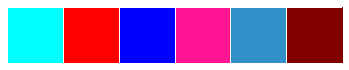

In [5]:
# Generate Stimulus on and Off times
import generate_stim_on_and_off_times
reload(generate_stim_on_and_off_times)
from generate_stim_on_and_off_times import GetStimulusOnOffTimes

available_experiments = ['2Stimx3', '1color4stim', '1Stimx4New', 'HighSpeed13fps', 'FarRedBluex3', 'HighSpeed23fps', 'RedBlueHighSpeedLQ', 'BlueRedx2']
stimulus_on_time, stimulus_off_time, stimulus_train, color_mat = \
GetStimulusOnOffTimes('2Stimx3', light_type=light_type, time_end = time_end, frames_per_sec=frames_per_sec)\
.get_stimulus_parameters()


stimulus_on_time = stimulus_on_time[:4]
stimulus_off_time = stimulus_off_time[:4]
stimulus_train = stimulus_train[:4]
color_mat = color_mat[:4]


In [6]:
#Create directory for Figures
Figure_PDFDirectory = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, 'Figures') + filesep
if not os.path.exists(Figure_PDFDirectory):
    os.makedirs(Figure_PDFDirectory)
FishName =  os.path.basename(os.path.normpath(FolderName)) #Get fishname to append to Figures

In [7]:
#Create directories to store Series Dataset
SeriesDirectory = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, 'SeriesDatasets') + filesep
if not os.path.exists(SeriesDirectory):
    os.makedirs(SeriesDirectory)

In [8]:
#Create directories to store result npz
NpzDirectory = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, 'NumpyArrays') + filesep
if not os.path.exists(NpzDirectory):
    os.makedirs(NpzDirectory)

### 2.Preprocess data

In [9]:
#Load functions for preprocessing first
import functions_for_preprocessing
reload(functions_for_preprocessing)
from functions_for_preprocessing import class_preprocess_data
analyze = class_preprocess_data(tsc, time_baseline, stimulus_on_time, stimulus_off_time, stimulus_train, SeriesDirectory)

In [10]:
filename = os.path.join(FolderName, region_to_analyze, stimulus_to_analyze, '16bit') + filesep
print filename
#Raise error if no such folder exists
if not(os.path.isdir(filename)):
    raise(ValueError('There are no such folders'))

/Users/seetha/Desktop/SingleCellAnalysis/Data/AF4lesion/Tiff/Fish654_AF10Control/Tiff/dhb_AF4_AF9/BlueRed/16bit/


In [11]:
# Crop Image
crop = 1 
img_size_crop_y1 = 5  # How many pixels to crop on x and y axis. If none say 0
img_size_crop_y2 = 5
img_size_crop_x1 = 5  
img_size_crop_x2 = 5

# Registration
register = 0

In [12]:
PrintSystemMemory()

Wired Memory:		1205 MB
Active Memory:		2312 MB
Inactive Memory:	1260 MB
Free Memory:		608 MB
Real Mem Total (ps):	3717.480 MB


In [13]:
# LOad data  
pp = PdfPages(Figure_PDFDirectory + FishName+'_Preprocessed_Data.pdf')
if savemode_loaddata:    
    data = analyze.load_and_preprocess_data(filename, crop, register, img_size_crop_x1, img_size_crop_x2, img_size_crop_y1,
                                 img_size_crop_y2,  medianfilter_window=median_filter_idx, start_frame=0, end_frame=time_end, pdffile=pp)
else:     
    if register:
        data = analyze.loadseriesdataset('registered_data')
    else:
        data = analyze.loadseriesdataset('raw_data')

Loading pre saved series dataset


In [14]:
img_raw = data.seriesMean().pack()
examples = analyze.get_small_subset_for_plotting(data, number_samples=100, threshold=50)

In [15]:
time_experiment = time_end
print 'Time points in experiment..', time_experiment

Time points in experiment.. 204


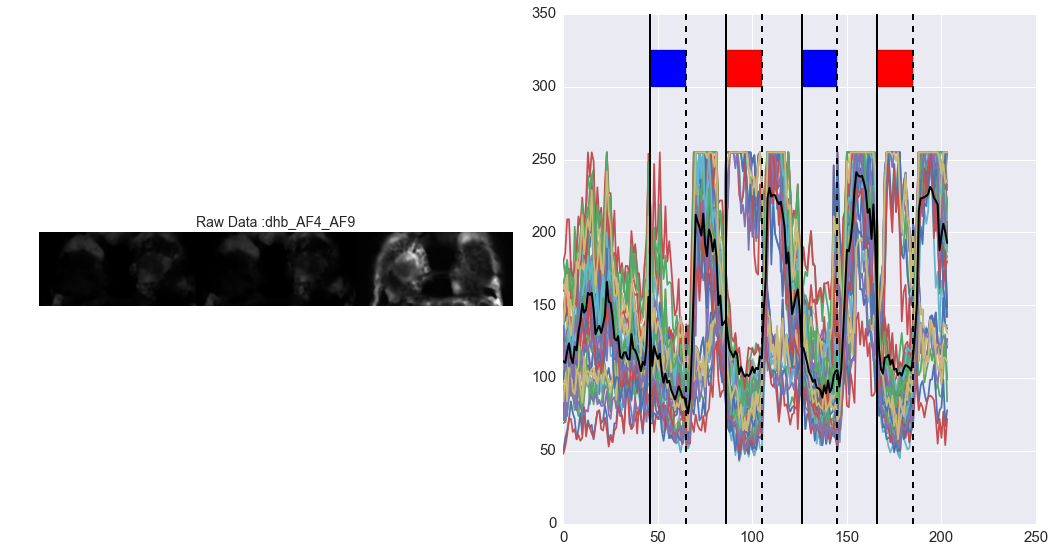

In [16]:
# Plot mean and traces of data and check whether to detrend or not
fig1 = plt.figure(figsize=(15,8))
gs = plt.GridSpec(1, 2)
title = 'Raw Data :'
analyze.plotimageplanes(fig1, gs, img_raw, plot_title= title + region_to_analyze, gridspecs='[0, 0]')
analyze.plot_traces(fig1, gs, examples, gridspecs='[0, 1]')
plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')
pp.close()

In [17]:
PrintSystemMemory()

Wired Memory:		1218 MB
Active Memory:		2745 MB
Inactive Memory:	1313 MB
Free Memory:		153 MB
Real Mem Total (ps):	4192.145 MB


## Subtract Background

In [18]:
background_subtraction_flag = 0
if background_subtraction_flag:
    if savemode_background:

        subtracted_data, bg_trace = analyze.background_subtraction(data)

        examples = analyze.get_small_subset_for_plotting(subtracted_data, number_samples=100, threshold=50)
        img_bgsub = subtracted_data.seriesMean().pack()

        pp = PdfPages(Figure_PDFDirectory + FishName+'_BackgroundSubtracted.pdf')
        fig1 = plt.figure(figsize=(15,5))
        gs = plt.GridSpec(1, 3)
        analyze.plotimageplanes(fig1, gs, img_raw, plot_title= 'Bg_subtraction ' + title + region_to_analyze, gridspecs='[0, 0]')
        analyze.plot_traces(fig1, gs, examples, gridspecs='[0, 1]')
        analyze.plot_traces(fig1, gs, bg_trace.first()[1], gridspecs='[0, 2]')
        plt.tight_layout()
        plt.show()
        pp.savefig(fig1, bbox_inches='tight')
        pp.close()

    else:
        subtracted_data = analyze.loadseriesdataset('bgubtracted_data')

## Non-linear detrend of data

In [19]:
if savemode_detrenddata: 
    data_detrend = analyze.detrend_data(data, detrend_order=2)
else:    
    data_detrend = analyze.loadseriesdataset('detrended_data')

Saving as series dataset fromdetrended_data


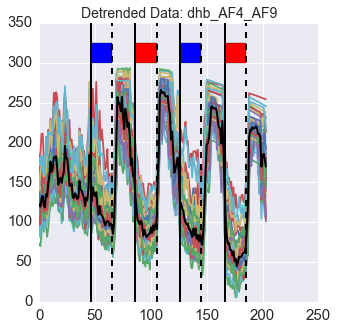

In [20]:
pp = PdfPages(Figure_PDFDirectory + FishName +'_DetrendedData.pdf')
examples = analyze.get_small_subset_for_plotting(data_detrend, number_samples=100, threshold=50)
    
#Plot
fig1 = plt.figure(figsize=(5, 5))
gs = plt.GridSpec(1,1)
analyze.plot_traces(fig1, gs, examples, \
                        plot_title='Detrended Data: ' + region_to_analyze)
pp.close()

In [21]:
PrintSystemMemory()

Wired Memory:		1201 MB
Active Memory:		2079 MB
Inactive Memory:	2054 MB
Free Memory:		16 MB
Real Mem Total (ps):	4173.348 MB


### 3. Normalize data

In [25]:
if savemode_zscoredata:   
    zscore = analyze.normalize(data_detrend, squelch_parameter=10)
else:
    zscore = analyze.loadseriesdataset('zscore_data')

Baseline being used for normalizing is ... 0  to  30
Saving as series dataset fromzscore_data


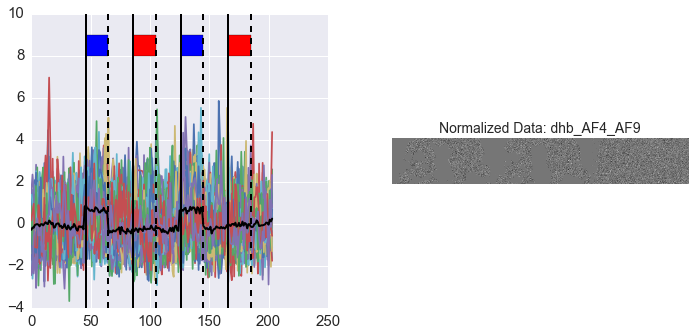

In [26]:
pp = PdfPages(Figure_PDFDirectory + FishName +'_Normalized.pdf')

examples = analyze.get_small_subset_for_plotting(zscore, number_samples=100, threshold=0.5)
img = zscore.seriesMean().pack()

fig1 = plt.figure(figsize=(10,5))
gs = plt.GridSpec(1,2)
analyze.plotimageplanes(fig1, gs, img,  plot_title='Normalized Data: '+region_to_analyze, gridspecs='[0, 1]')
analyze.plot_traces(fig1, gs, examples, gridspecs='[0,0]')
plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')
pp.close()

In [24]:
PrintSystemMemory()

Wired Memory:		1180 MB
Active Memory:		1801 MB
Inactive Memory:	1804 MB
Free Memory:		19 MB
Real Mem Total (ps):	3440.684 MB


## Smooth Data

In [27]:
windowlen = 3
if savemode_smootheddata:    
    zscore_smooth = zscore.toTimeSeries().smooth(window_len=windowlen) 
    analyze.saveasseries(data=zscore_smooth, savefilename='smoothed_data')
else:
    zscore_smooth = analyze.loadseriesdataset('smoothed_data')

Saving as series dataset fromsmoothed_data


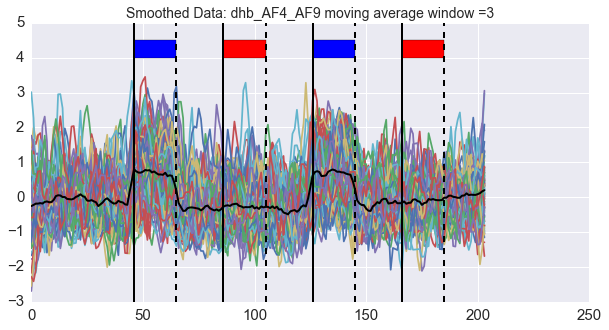

In [28]:
pp = PdfPages(Figure_PDFDirectory + FishName +'Smoothed.pdf')
examples = analyze.get_small_subset_for_plotting(zscore_smooth, number_samples=100, threshold=0.005)  
    
fig1 = plt.figure(figsize=(10,5))
gs  = plt.GridSpec(1,1)
analyze.plot_traces(fig1, gs, examples, num_subplots=1, \
                   plot_title='Smoothed Data: ' + region_to_analyze + \
                    ' moving average window =' + str(windowlen))
plt.show()
pp.savefig(fig1)
pp.close()

In [ ]:
PrintSystemMemory()

## PCA

In [ ]:
PCA_data = zscore

In [ ]:
# PCA parameters 
pca_components_ind = 3  # Number of pca components to detect from files
num_pca_colors = 30  # Number of colors on the pca maps
num_samples = 10000  # number of random samples to select to do PCA reconstruction
thresh_pca = 0.0001  # Threshold above which to plot the pca components
color_map = "polar"


In [ ]:
#Load functions for PCA
import functions_for_PCA
reload(functions_for_PCA)
from functions_for_PCA import class_PCA
PCA = class_PCA(pca_components_ind, PCA_data, img_raw, num_pca_colors, num_samples,\
                    thresh_pca, color_map, color_mat,stimulus_on_time, stimulus_off_time, stimulus_train)

In [ ]:
#Run PCA
required_pcs = [0, 1]

In [ ]:
model_PCA = PCA.run_pca()

In [ ]:
imgs = PCA.get_pca_scores(model_PCA, required_pcs)

In [ ]:
maps, pts, clrs, recon, unique_clrs_PCA, matched_pixels_PCA, \
               matched_signals, mean_signal, sem_signal = PCA.make_pca_maps(model_PCA, imgs, \
                                                       required_pcs, mixing_parameter=1)

In [ ]:
pca_components = model_PCA.comps.T
pca_eigenvalues = model_PCA.latent

In [ ]:
pp = PdfPages(Figure_PDFDirectory + FishName + '_PCA.pdf')

fig1 = plt.figure(figsize=(15,10))

gs = plt.GridSpec(3,5, height_ratios=[0.25,0.25,1], width_ratios=[0.5,1.5,0.25,0.5,1.5, 1.5])
PCA.plot_pca_components(fig1, gs, pca_components, required_pcs, plot_title='PCA components : ' + region_to_analyze, gridspecs='[0,0:2]')

PCA.plot_eigenvalues(fig1, gs, pca_eigenvalues, gridspecs='[1, 0:2]')

if len(required_pcs) == 3:
    PCA.plot_stimulus_in_3d(fig1, gs, pca_components, required_pcs, 'z', gridspecs='[2,0:2]')
else:
    PCA.plot_stimulus_in_2d(fig1, gs, pca_components, required_pcs, gridspecs='[2,0:2]')

plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')

In [ ]:
fig1 = plt.figure(figsize=(25,10))
gs = plt.GridSpec(6,5, width_ratios=[5,0.2,5,0.5,1])
PCA.plotimageplanes(fig1, gs, maps , plot_title='PCA map: ' + region_to_analyze,\
                        gridspecs='[0:3,0]')

PCA.plot_scores_individually(fig1, gs, mean_signal, sem_signal, unique_clrs_PCA, plot_title='PCA scores : ' + region_to_analyze, gridspecs='[0, 2]')

PCA.plot_matchedpixels(fig1, gs, matched_pixels_PCA, unique_clrs_PCA, gridspecs='[0:3,4]')

plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')

pp.close()

In [ ]:
mean_signal

In [ ]:
np.savez(NpzDirectory + 'pca_results.npz', pca_components=pca_components,
                 pca_eigenvalues=pca_eigenvalues, new_imgs=imgs, maps=maps, pts=pts, clrs=clrs,
                 recon=recon, unique_clrs=unique_clrs_PCA, matched_pixels=matched_pixels_PCA, matched_signals=matched_signals,
                 mean_signal=mean_signal, sem_signal=sem_signal, required_pcs=required_pcs)

## Run Kmeans

In [41]:
#Kmeans_Parameters
kmeans_clusters_num = 10
kmeans_data = zscore_smooth

In [42]:
#Load functions for kmeans 
import functions_for_kmeans
reload(functions_for_kmeans)
from functions_for_kmeans import class_kmeans
kmeans = class_kmeans(kmeans_clusters_num, kmeans_data, img_raw, stimulus_on_time, stimulus_off_time, stimulus_train)

In [43]:
# Perform kmeans
model_kmeans, img_sim, img_labels = kmeans.run_kmeans()

In [44]:
kmeans_clusters = model_kmeans.centers.T

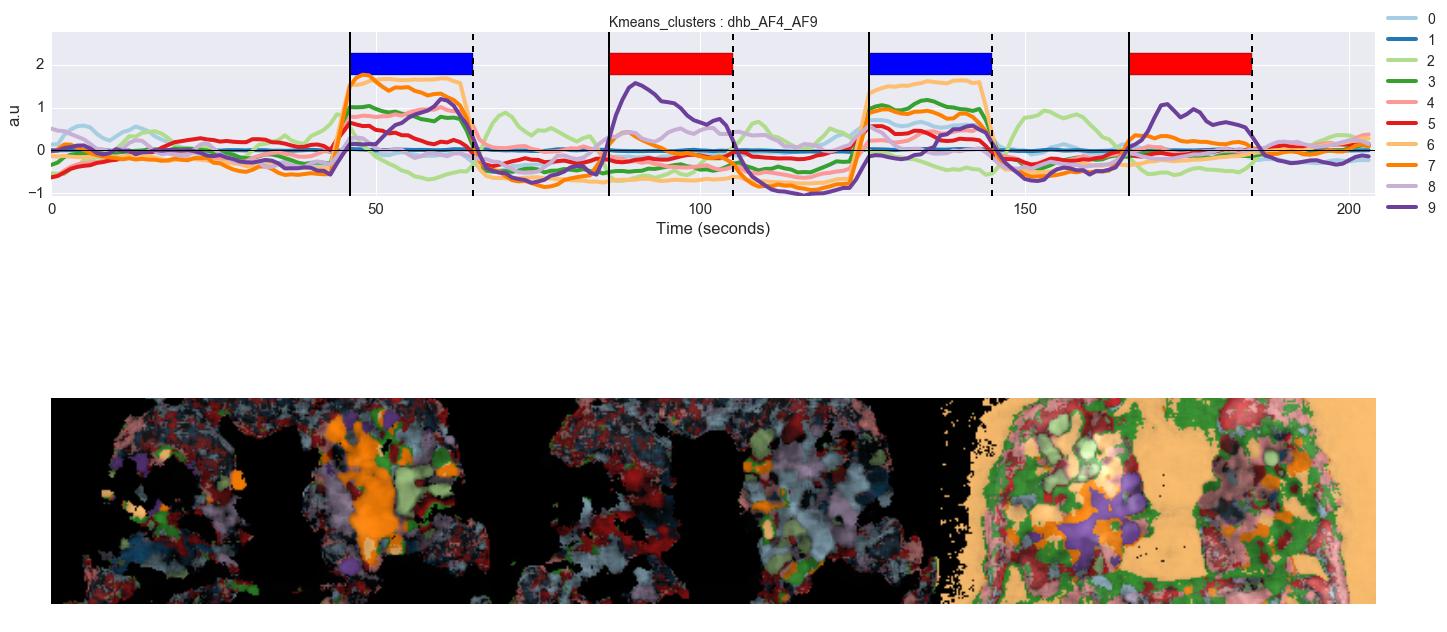

In [45]:
#Check plots with a random colormap
fig1 = plt.figure(figsize=(20,10))
gs = plt.GridSpec(8, 8)
cmapCat = ListedColormap(sns.color_palette("Paired", n_colors=kmeans_clusters_num), name='from_list')
centered_cmap = kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters[:,:], cmapCat,
                                  plot_title='Kmeans_clusters : ' + region_to_analyze, 
                                  gridspecs='[0,0]', model_center=0)
kmeans.createbrainmap_withcmap(fig1,gs, centered_cmap, img_labels, img_sim, mixing_parameter = 0.5, gridspecs='[3:,0:]')
plt.tight_layout()

plt.show()

In [39]:
#Use a colorbrewer colormap to create map of brain
ignore_clusters = [1];

brainmap, unique_clrs, newclrs_updated_rgb, newclrs_updated_brewer, matched_pixels, \
kmeans_clusters_updated = kmeans.make_kmeans_maps(kmeans_clusters, \
                                                          img_labels, img_sim, mixing_parameter=1,
                                                          std_threshold=0.0005, ignore_clusters=ignore_clusters)

Standard deviation of clusters is.. [ 0.02034829  0.78195314  0.58010327  0.28046903  0.48441932  0.45263487
  0.4414435   0.41386892  0.25818592  0.40129534]
Interesting clusters after STD are.. [[0 1 2 3 4 5 6 7 8 9]]
Interesting clusters after user specified clusters.. [0 2 3 4 5 6 7 8 9]


1


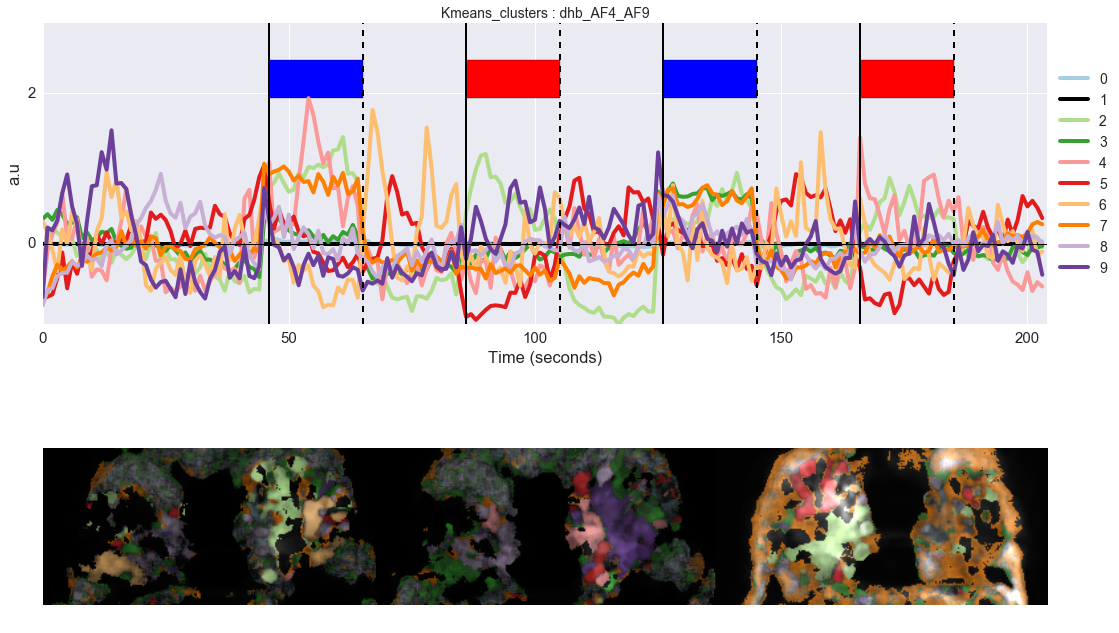

In [40]:
pp = PdfPages(Figure_PDFDirectory + FishName + '_KMeans.pdf')
fig1 = plt.figure(figsize=(15,10))
gs = plt.GridSpec(6, 4, width_ratios=[1,0.2,1,1])
cmapCat = ListedColormap(sns.color_palette("Paired", n_colors=kmeans_clusters_num), name='from_list')
centered_cmap = kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters[:,:], cmapCat,\
                                  plot_title='Kmeans_clusters : ' + region_to_analyze,
                                  num_subplots=1, gridspecs='[0,0]', model_center=0,\
                                              removeclusters = ignore_clusters)

kmeans.createbrainmap_withcmap(fig1,gs, centered_cmap, img_labels, img_sim, mixing_parameter = 1.0, gridspecs='[3:,0:]')

plt.tight_layout()
pp.savefig(fig1, bbox_inches='tight')

In [ ]:
# pp = PdfPages(Figure_PDFDirectory + FishName + '_KMeans1.pdf')
A = copy(centered_cmap.colors)
B = copy(centered_cmap.colors)
A[1] = B[11]
A[13] = B[11]
A[11] = B[13]
A = ListedColormap(A, name='from_list')
fig1 = plt.figure(figsize=(10,10))
gs = plt.GridSpec(6, 4, width_ratios=[1,0.2,1,1])
kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters[:,:], A,\
                                  plot_title='Kmeans_clusters : ' + region_to_analyze,
                                  num_subplots=1, gridspecs='[0,0]', model_center=0,\
                                              removeclusters = ignore_clusters)
kmeans.createbrainmap_withcmap(fig1,gs, A, img_labels, img_sim, mixing_parameter = 1.0, gridspecs='[1:,0:]')
plt.tight_layout()

centered_cmap.colors = A.colors
print A.colors

In [ ]:
fig1 = plt.figure(figsize=(20,5))
gs = plt.GridSpec(1,5,width_ratios=[5,0.1,3,0.5,1])
kmeans.plotimageplanes(fig1, gs, brainmap , plot_title='Brain Map : '+region_to_analyze, gridspecs='[0,0]')
kmeans.plot_kmeans_components(fig1, gs, kmeans_clusters_updated, newclrs_updated_brewer,\
                              plot_title='Kmeans_clusters : ' + region_to_analyze, num_subplots=2, \
                              flag_separate=0, gridspecs='[0,2]', model_center=0)
kmeans.plot_matchedpixels(fig1, gs, matched_pixels, unique_clrs, gridspecs='[0,4]')

plt.tight_layout()
plt.show()
pp.savefig(fig1, bbox_inches='tight')

In [ ]:
pp.close()

In [ ]:
np.savez(NpzDirectory + 'kmeans_results.npz', kmeans_clusters=kmeans_clusters, ignore_clusters=ignore_clusters, 
         kmeans_clusters_updated=kmeans_clusters_updated, img_labels = img_labels, img_sim = img_sim, 
         brainmap = brainmap, unique_clrs = unique_clrs, newclrs_updated_rgb = newclrs_updated_rgb, reference_image = img_raw, 
         newclrs_updated_brewer = newclrs_updated_brewer, matched_pixels = matched_pixels, centered_cmap=centered_cmap.colors)

## Run CNMF

In [ ]:
#CNMF Parameter
NMF_Data = zscore

In [ ]:
# CNMF parameters 
nmf_number_of_components = 5 # Number of pca components to detect from files
nmf_max_iterations = 15
nmf_tolerance_level = 0.001
nmf_color_map = 'indexed'  # Colormap for plotting NMF components
nmf_colors = sns.color_palette("Paired", n_colors=nmf_number_of_components)

print 'ColorMAP..shape (%d, %d) \n' % (np.shape(nmf_colors))
sns.palplot(nmf_colors)

In [ ]:
#Load functions for PCA
import functions_for_NMF
reload(functions_for_NMF)
from functions_for_NMF import class_NMF
NMF = class_NMF(nmf_number_of_components, NMF_Data, img_raw, nmf_colors, nmf_color_map, nmf_max_iterations, nmf_tolerance_level,
                 stimulus_on_time, stimulus_off_time, stimulus_train, frames_per_sec)

In [ ]:
NMF_model, NMF_image = NMF.run_NMF()

In [ ]:
NMF_components = NMF_model.h.T
NMF_maps, NMF_matched_pixels, NMF_unique_clrs = NMF.make_NMF_maps(NMF_image,  mixing_parameter=0.3)

In [ ]:
pp = PdfPages(Figure_PDFDirectory + FishName + '_NMF.pdf')

fs = plt.figure(figsize=(15,10))
gs = plt.GridSpec(4, 2, width_ratios=[1, 1.5])

ax1 = fs.add_subplot(gs[0:2, :])
plt.imshow(NMF_maps, aspect=None)
plt.axis('off')

NMF.plot_nmf_components(fs, gs, NMF_components, plot_title='Habneula', gridspecs='[2,:]')
plt.tight_layout()

pp.savefig()
pp.close()

In [ ]:
np.savez(NpzDirectory + 'nmf_results1.npz', nmf_number_of_components = nmf_number_of_components, 
         nmf_max_iterations = nmf_max_iterations, nmf_tolerance_level = nmf_tolerance_level,
         nmf_color_map = nmf_color_map, nmf_colors = nmf_colors, NMF_components = NMF_components, NMF_maps = NMF_maps, 
         NMF_matched_pixels = NMF_matched_pixels, NMF_unique_clrs = NMF_unique_clrs, NMF_image = NMF_image, 
         img_reference=img_raw)